# Variational Autoencoders
This code is based on this blog post: http://kvfrans.com/variational-autoencoders-explained/, which replicates work on VAE from https://arxiv.org/abs/1312.6114 (Kingma, 2013).

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

from datetime import datetime

from utils import *

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
tf.reset_default_graph()


In [4]:
n_z = 20
batchsize = 32

# ENCODER
X = tf.placeholder(tf.float32, shape=[None, 784])
X_reshape = tf.reshape(X, [-1, 28,28,1])
def encoder(x):
    with tf.variable_scope("encoder"):
        h1 = lrelu(conv2d(x, 1, 16, "d_h1")) # 28x28x1 -> 14x14x16
        h2 = lrelu(conv2d(h1, 16, 32, "d_h2")) # 14x14x16 -> 7x7x32
        h2_flat = tf.reshape(h2,[-1, 7*7*32])
        w_mean = dense(h2_flat, 7*7*32, n_z, "w_mean")
        w_stddev = dense(h2_flat, 7*7*32, n_z, "w_stddev")
    return w_mean, w_stddev


# DECODER
def decoder(z):
    with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
        z_develop = dense(z, n_z, 7*7*32, scope='z_matrix')
        z_matrix = tf.nn.relu(tf.reshape(z_develop, [-1, 7, 7, 32]))
        h1 = tf.nn.relu(conv_transpose(z_matrix, [batchsize, 14, 14, 16], "g_h1"))
        h2 = conv_transpose(h1, [batchsize, 28, 28, 1], "g_h2")
        h2 = tf.nn.sigmoid(h2)
    return h2



z_mean, z_stddev = encoder(X_reshape)

samples = tf.random_normal([batchsize, n_z], 0, 1, dtype=tf.float32)
z_code = z_mean + (z_stddev * samples)

generated_images = decoder(z_code)
generated_flat = tf.reshape(generated_images, [-1, 784])


# LOSS
generation_loss = -tf.reduce_sum(X * tf.log(1e-8 + generated_flat) + 
                                 (1-X) * tf.log(1e-8 + 1 - generated_flat)
                                 ,1)
latent_loss = 0.5 * tf.reduce_sum(tf.square(z_mean) + tf.square(z_stddev) - tf.log(1e-8 + tf.abs(z_stddev)) - 1,1)
loss = tf.reduce_mean(generation_loss + latent_loss)

optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

In [5]:
samples_fake = tf.random_normal([32, n_z], 0, 1, dtype=tf.float32)
#samples_fake = tf.random_normal([n_z], 0, 1, dtype=tf.float32)
#samples_fake = tf.ones([32,n_z]) * samples_fake
fake_images = decoder(samples_fake)

In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [7]:
mb_size = batchsize
for it in range(9000):
    X_mb, _ = mnist.train.next_batch(mb_size)

    _, gen_loss, lat_loss = sess.run((optimizer, generation_loss, latent_loss), 
                                     feed_dict={X: X_mb})
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('gen_loss: {:.4}'. format(np.mean(gen_loss)))
        print('lat_loss: {:.4}'.format(np.mean(lat_loss)))
        print(str(datetime.now()))
        print()

Iter: 0
gen_loss: 543.4
lat_loss: 50.15
2018-07-08 13:18:18.268621

Iter: 1000
gen_loss: 119.2
lat_loss: 13.36
2018-07-08 13:18:40.670949

Iter: 2000
gen_loss: 106.3
lat_loss: 16.15
2018-07-08 13:19:03.484160

Iter: 3000
gen_loss: 110.0
lat_loss: 16.03
2018-07-08 13:19:24.103046

Iter: 4000
gen_loss: 85.73
lat_loss: 13.96
2018-07-08 13:19:51.622279

Iter: 5000
gen_loss: 102.3
lat_loss: 15.67
2018-07-08 13:20:15.267227

Iter: 6000
gen_loss: 101.7
lat_loss: 26.35
2018-07-08 13:20:36.996647

Iter: 7000
gen_loss: 87.42
lat_loss: 15.08
2018-07-08 13:20:57.887669

Iter: 8000
gen_loss: 85.53
lat_loss: 18.63
2018-07-08 13:21:18.414053



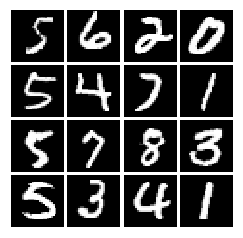

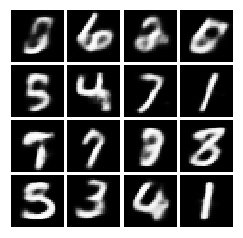

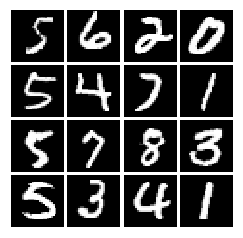

In [104]:
g, r, z, z_mean, z_stddev = sess.run([generated_images, X_reshape, z_code, z_mean, z_stddev], feed_dict={X: X_mb})
plot(g)
plot(r)

In [94]:
z_mean.mean()

nan

In [87]:
z_stddev

array([[-0.2117701 ,  0.30972821,  0.34033766, -0.30084312, -0.25705734,
        -0.24971001,  0.48943284,  1.22855389,  0.38461703,  0.42849451,
         0.15330452, -0.18080147, -0.32440299, -0.30053788, -0.49409112,
         0.16084529, -0.34618187,  0.15630183,  1.44804335, -0.35996947],
       [-0.19221835,  0.15651834,  0.41268995, -0.17412817, -0.29260159,
        -0.21561474,  0.32216558,  1.08402848,  0.33398214,  0.52086204,
         0.24428523, -0.10874249, -0.40157267, -0.40686947, -0.30047727,
         0.17609012, -0.33652523,  0.21055719,  1.07505095, -0.56213129],
       [-0.27085799,  0.22269826,  0.34077021, -0.29923239, -0.33312365,
        -0.25785303,  0.66149795,  1.10232687,  0.39881274,  0.42003506,
         0.15593705, -0.2013385 , -0.44224113, -0.53592861, -0.57552356,
         0.27180797, -0.30628109,  0.15794963,  1.22830832, -0.64322072],
       [-0.22346316,  0.32066265,  0.37030435, -0.33162004, -0.41919297,
        -0.26928666,  0.32107243,  1.33222365,  

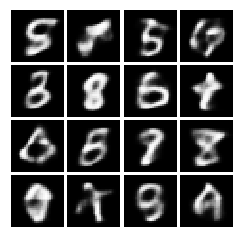

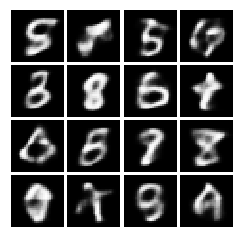

In [106]:
plot(sess.run(fake_images,feed_dict={X: X_mb}))